# Cuaderno 29: Formulación de planos cortantes para el ATSP
## (con separación de soluciones fraccionarias)

$\newcommand{\card}[1]{\left| #1 \right|}$
$\newcommand{\tabulatedset}[1]{\left\{ #1 \right\}}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$

Dados: 
* un grafo dirigido **completo** $D=(V,A)$; y,
* un vector $c \in \ZZ^{A}$ de costos asociados a los arcos de $D$.

El *problema del agente viajero asimétrico (Asymmetric Traveling Salesman Problem, ATSP)* consiste en encontrar un circuito dirigido que visite **todos** los nodos de $G$ y que tenga el menor costo posible.

Vamos a considerar una formulación como programa lineal entero para el ATSP que emplea desigualdades de cortes para eliminar subciclos (ver Cuaderno 25 para el caso simétrico):

\begin{align*}
\min &\sum_{(i,j) \in A} c_{ij} x_{ij}\\ 
& \mbox{s.r.}\\
&\sum_{(i,j) \in \delta^{+}(i) } x_{ij} = 1, \quad \forall i \in V,\\
&\sum_{(j,i) \in \delta^{-}(i) } x_{ji} = 1, \quad \forall i \in V,\\
&\sum_{ij \in \delta^{+}(W)} x_{ij} \geq 1, \quad \forall W \subset V, \emptyset \neq W \neq V,\\
& x_{ij} \in \{0, 1\}, \quad \forall (i,j) \in A,
\end{align*}
donde $\delta^{+}(W) := \{ (i,j) \in A \, : \, i \in W, j \not\in W\}$.

En este cuaderno vamos a implementar un algoritmo de planos cortantes para separar las restricciones de corte, basado en el algoritmo de corte de capacidad mínima presentado en el Cuaderno 28.


Definimos primero los datos. Usaremos la función `randint` del módulo random para generar valores aleatorios en el rango {0,..,100} para las coordenadas de cada nodo. Los costos de los arcos serán iguales a las distancias euclideanas entre sus nodos extremos. 

In [1]:
from gurobipy import *
import random as rm
import math 

# iniciar generador de numeros aleatorios
rm.seed(0)

# Numero de nodos del grafo
n = 50

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
A = c.keys()


Emplearemos el módulo `matplotlib` para graficar el tour de la solución. Definiremos para ello la función `dibujarTour` que recibe tres argumentos: una lista `coordx` con las coordenadas horizontales de los nodos, una lista `coordy` con las coordenadas verticales y un vector `tour` con una permutación de los nodos indicando el orden de visita en la solución.

In [2]:
import matplotlib.pyplot as plt
import random

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.figure(figsize=(15, 15))
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

Para la generación dinámica de las desigualdades de corte, necesitaremos calcular el corte saliente de capacidad mínima en un grafo dirigido. Emplearemos para ello la siguiente función descrita en el Cuaderno 28:

In [3]:
import networkx as nx

# corte saliente de capacidad minima
def corte_sal_minimo(V, u):
    # Parametros:
    # V: lista con los nodos del grafo
    # u: diccionario indexado por los arcos del grafo, con sus capacidades
    # se fija un nodo s arbitrario
    s = V[0]
    V2 = [i for i in V if i!=s]
    G = nx.DiGraph()
    G.add_weighted_edges_from([(i, j, u[i,j]) for (i,j) in u.keys()], weight='u')
    # inicializar dmin con la suma de capacidades de todos los arcos
    dmin = sum([u[i,j] for (i, j) in u.keys()])
    hay_solucion = False
    # se calculan los cortes minimos (s, t) y (t, s) para todo t != s
    for t in V2: 
        d1, (W1, W1c) = nx.minimum_cut(G, s, t, capacity='u')
        d2, (W2, W2c) = nx.minimum_cut(G, t, s, capacity='u')
        if d1 < d2 and d1 < dmin:
            dmin, Wmin, Wminc = d1, W1, W1c
            hay_solucion = True
        elif d2 <= d1 and d2 < dmin:
            dmin, Wmin, Wminc = d2, W2, W2c
            hay_solucion = True
    if  not hay_solucion:
        print('*** Error:')
        print(V)
        for (i,j) in [(i, j) for (i, j) in u.keys() if i==1]:
            print([(1,j), u[1,j]])
    return dmin, Wmin, Wminc


Definimos ahora el objeto modelo, las variables y la función objetivo. 

Definimos las variables miembro `_x`, `_V` y `_A` dentro del objeto modelo para tener acceso a las variables de selección de arcos, la lista de nodos y la lista de arcos, respectivamente. 

In [4]:
# Crear el objeto modelo
m = Model('atsp-corte-lazy')

# Crear las variables
x = m.addVars(A, name="x", vtype=GRB.BINARY)

# Crear la funcion objetivo
m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

# Crear variables en el objeto modelo para tener acceso a x, V y A
m._x = x
m._V = V
m._A = A

Using license file /Users/ltorres/gurobi.lic
Academic license - for non-commercial use only


Añadimos las restricciones de grado. 

In [5]:
# Restricciones de grado saliente
m.addConstrs((x.sum(i,'*') == 1 for i in V), "g_saliente");

# Restricciones de grado entrante
m.addConstrs((x.sum('*', i) == 1 for i in V), "g_entrante");



Definimos una función callback para separar dinámicamente las restricciones de corte. Esta función actúa cada vez que el solver encuentra una nueva solución entera que satisface las restricciones de grado (`where == GRB.Callback.MIPSOL`), o cuando termina el procesamiento de un nodo del árbol de branch-and-bound y se dispone de una solución fraccionaria a la relajación lineal problema (`where == GRB.Callback.MIPNODE`). 

Cuando se dispone de una solución entera, la función accede a los valores de las variables a través del llamado a `cbGetSolution`. A partir de estos valores, la función implementa un algoritmo de marcaje para determinar el conjunto W de todos los nodos que pueden ser alcanzados desde el nodo 1. Si este conjunto es distinto de V, el mismo está asociado a una desigualdad de corte violada por `x`.

Cuando la función callback es llamada luego del procesamiento de un nodo del árbol de branch-and-bound (`where == GRB.Callback.MIPNODE`), es necesario en primer lugar verificar que se dispone de una solución fraccionaria, llamando a la función `cbGet(GRB.Callback.MIPNODE_STATUS)` y comparando su valor de retorno con `GRB.OPTIMAL`. En este caso, los valores de la solución fraccionaria son recuperados llamando a la función `cbGetNodeRel`. Estos valores se usan como capacidades en los arcos del grafo del problema. Se emplean las funciones descritas en el Cuaderno 28 para calcular un corte de capacidad mínimima en el grafo. Si la capacidad de este corte es inferior a 1, se separa la desigualdad correspondiente.

In [6]:
# Funcion callback para separar desigualdades de corte
def mycallback(model, where):
    # Esta funcion se activara cuando se encuentre una nueva solucion entera
    if where == GRB.Callback.MIPSOL:
        # Recuperar los valores de la solucion actual
        vx = model.cbGetSolution(model._x)
        # Determinar los arcos seleccionados en la solucion
        L = [(i,j) for (i,j) in model._A if vx[i,j]>0.1]
        # Construir la lista W de nodos que pueden ser alcanzados desde 1
        W = [1]
        i = 1
        while True :
            N = [k for k in model._V if (i,k) in L]
            if len(N)>1:
                print("Error en desigualdad de grado:")
                for k in N:
                    print("{}-->{}: {}".format(i,k, vx[i,k]))
            j = N.pop()
            a = (i,j) 
            L.remove(a)
            if j==1: break
            W.append(j)
            i = j
        # Si W!=V, agregar la desigualdad de corte asociada a W
        if len(W)!=len(model._V):
            Wc = [i for i in model._V if i not in W]
            model.cbLazy(model._x.sum(W, Wc) >= 1)
    # Esta funcion se activara cuando se encuentre la solucion optima en un nodo
    elif where == GRB.Callback.MIPNODE:
        if model.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
            # Recuperar los valores de la solucion (fraccionaria) actual
            vx = model.cbGetNodeRel(model._x)
            # Crear diccionario de capacidades (=valores de x) indexado por los arcos
            D={}
            for (i,j) in model._A:
                D[i,j] = vx[i,j]
            # encontrar el corte saliente de capacidad minima
            u, W, Wc = corte_sal_minimo(model._V, D)
            # Si la capacidad de este corte es inferior a 1, agregar nueva desigualdad lazy
            if u <= 0.99:
                model.cbLazy(model._x.sum(W, Wc) >= 1)


Escribimos el modelo a un archivo de texto:

In [9]:
# Escribir el modelo a un archivo
m.write('atsp-corte-lazy.lp')


Para poder utilizar restricciones tipo *lazy* en un modelo, debe fijarse el parámetro `LazyConstraints` al valor de 1.

In [7]:
# Configurar Gurobi para usar restricciones lazy
m.Params.LazyConstraints = 1


Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0


Fijamos un límite para el tiempo de cálculo y una tolerancia para la brecha de optimalidad:

In [8]:
# Terminar al alcanzar un Gap del 10%
m.Params.MIPGap = 0.1

# Terminar luego de 240 segundos
m.Params.TimeLimit = 240

Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 240.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


Finalmente, resolvemos el modelo y mostramos la solución, en caso de que se haya encontrado una solución factible (si `m.status` es `GRB.Status.OPTIMAL` o `GRB.Status.SUBOPTIMAL`).

In [9]:
# Se recomienda llamar a update() antes de resolver un modelo que usa restricciones lazy
m.update()

# Calcular la solucion optima
m.optimize(mycallback)

# Escribir la solucion
if ((m.status == GRB.Status.OPTIMAL) or 
   (m.status == GRB.Status.SUBOPTIMAL)):
    # Recuperar los valores de las variables
    vx = m.getAttr('x', x)
    print('\nTour optimo:')
    for i,j in A:
        if vx[i,j] > 0:
            print('{} --> {}'.format(i, j))


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 100 rows, 2450 columns and 4900 nonzeros
Model fingerprint: 0x9b202e1a
Variable types: 0 continuous, 2450 integer (2450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2402.8467090
Presolve time: 0.03s
Presolved: 100 rows, 2450 columns, 4900 nonzeros
Variable types: 0 continuous, 2450 integer (2450 binary)

Root relaxation: objective 4.444313e+02, 86 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  452.64110    0   26 2402.84671  452.64110  81.2%     -    0s
     0     0  455.61721    0   32 2402.84671  455.61721  81.0%     -    1s
     0     2  461.65683    0   34 2402.84671  461.65683  80.8%     -    2s
     8     8

Si encontramos alguna solución factible, el siguiente fragmento de código nos permite graficarla.

[(1, 3), (2, 29), (3, 6), (4, 14), (5, 32), (6, 34), (7, 43), (8, 38), (9, 2), (10, 41), (11, 48), (12, 1), (13, 45), (14, 5), (15, 7), (16, 28), (17, 36), (18, 16), (19, 24), (20, 50), (21, 40), (22, 46), (23, 15), (24, 23), (25, 13), (26, 30), (27, 22), (28, 20), (29, 31), (30, 47), (31, 19), (32, 12), (33, 37), (34, 39), (35, 26), (36, 27), (37, 11), (38, 17), (39, 21), (40, 9), (41, 18), (42, 44), (43, 33), (44, 8), (45, 42), (46, 10), (47, 4), (48, 25), (49, 35), (50, 49)]


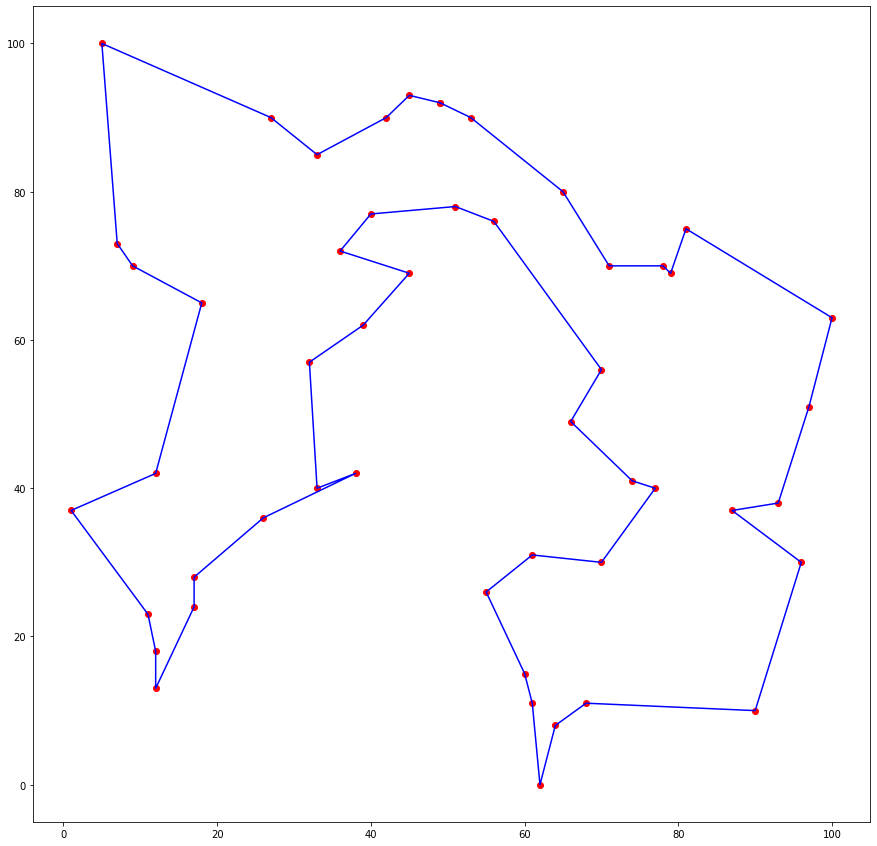

In [14]:
# Crear lista con arcos seleccionados en la solucion
vx = m.getAttr('x', x)
L = [(i,j) for i,j in A if vx[i,j]>0.1]
print(L)

# Recuperar el tour como un ordenamiento de los nodos
T = [1]
# nodo actual:
i = 1
while True:
    # Determinar sucesor de i
    N = [j for j in V if (i,j) in L]
    j = N.pop()
    a = (i,j) 
    L.remove(a)
    # Colocar sucesor en la lista del tour y actualizar i
    T.append(j)
    i = j
    # Terminar cuando el nodo colocado sea 1
    if i==1: break;
        
# Graficar el tour
dibujarTour(coordx, coordy, T)    

## Código completo

Se reproduce a continuación el código completo del modelo anterior.

Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 240.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 100 rows, 2450 columns and 4900 nonzeros
Model fingerprint: 0x9b202e1a
Variable types: 0 continuous, 2450 integer (2450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2402.8467090
Presolve time: 0.01s
Presolved: 100 rows, 2450 columns, 4900 nonzeros
Variable types: 0 continuous, 2450 integer (2450 binary)

Root relaxation: objective 4.444313e+02, 86 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

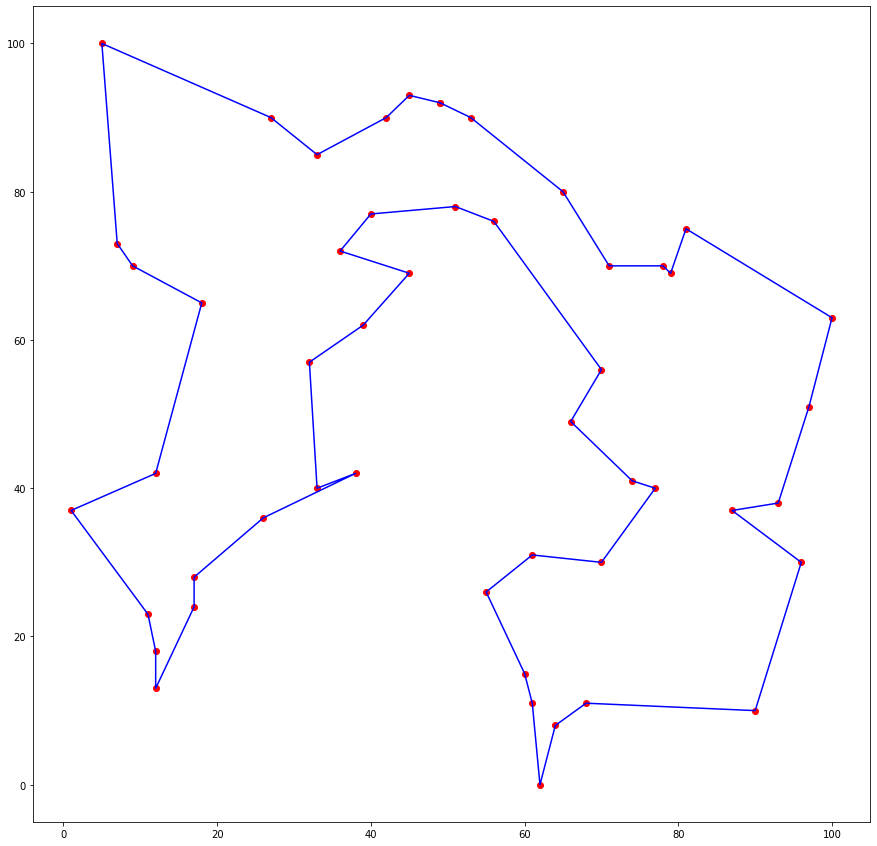

In [16]:
# Implementación de modelos lineales enteros
# Problema del agente viajero asimétrico (ATSP)
# Implementación con desigualdades lazy

# Luis M. Torres (EPN 2020)

from gurobipy import *
import random as rm
import math 
import networkx as nx

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.figure(figsize=(15, 15))
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

# Funciona para calcular un corte saliente de capacidad minima
def corte_sal_minimo(V, u):
    # Parametros:
    # V: lista con los nodos del grafo
    # u: diccionario indexado por los arcos del grafo, con sus capacidades
    # se fija un nodo s arbitrario
    s = V[0]
    V2 = [i for i in V if i!=s]
    G = nx.DiGraph()
    G.add_weighted_edges_from([(i, j, u[i,j]) for (i,j) in u.keys()], weight='u')
    # inicializar dmin con la suma de capacidades de todos los arcos
    dmin = sum([u[i,j] for (i, j) in u.keys()])
    hay_solucion = False
    # se calculan los cortes minimos (s, t) y (t, s) para todo t != s
    for t in V2: 
        d1, (W1, W1c) = nx.minimum_cut(G, s, t, capacity='u')
        d2, (W2, W2c) = nx.minimum_cut(G, t, s, capacity='u')
        if d1 < d2 and d1 < dmin:
            dmin, Wmin, Wminc = d1, W1, W1c
            hay_solucion = True
        elif d2 <= d1 and d2 < dmin:
            dmin, Wmin, Wminc = d2, W2, W2c
            hay_solucion = True
    if  not hay_solucion:
        print('*** Error:')
        print(V)
        for (i,j) in [(i, j) for (i, j) in u.keys() if i==1]:
            print([(1,j), u[1,j]])
    return dmin, Wmin, Wminc

# Funcion callback para separar desigualdades de corte
def mycallback(model, where):
    # Esta funcion se activara cuando se encuentre una nueva solucion entera
    if where == GRB.Callback.MIPSOL:
        # Recuperar los valores de la solucion actual
        vx = model.cbGetSolution(model._x)
        # Determinar los arcos seleccionados en la solucion
        L = [(i,j) for (i,j) in model._A if vx[i,j]>0.1]
        # Construir la lista W de nodos que pueden ser alcanzados desde 1
        W = [1]
        i = 1
        while True :
            N = [k for k in model._V if (i,k) in L]
            if len(N)>1:
                print("Error en desigualdad de grado:")
                for k in N:
                    print("{}-->{}: {}".format(i,k, vx[i,k]))
            j = N.pop()
            a = (i,j) 
            L.remove(a)
            if j==1: break
            W.append(j)
            i = j
        # Si W!=V, agregar la desigualdad de corte asociada a W
        if len(W)!=len(model._V):
            Wc = [i for i in model._V if i not in W]
            model.cbLazy(model._x.sum(W, Wc) >= 1)
    # Esta funcion se activara cuando se encuentre la solucion optima en un nodo
    elif where == GRB.Callback.MIPNODE:
        if model.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
            # Recuperar los valores de la solucion (fraccionaria) actual
            vx = model.cbGetNodeRel(model._x)
            # Crear diccionario de capacidades (=valores de x) indexado por los arcos
            D={}
            for (i,j) in model._A:
                D[i,j] = vx[i,j]
            # encontrar el corte saliente de capacidad minima
            u, W, Wc = corte_sal_minimo(model._V, D)
            # Si la capacidad de este corte es inferior a 1, agregar nueva desigualdad lazy
            if u <= 0.99:
                model.cbLazy(model._x.sum(W, Wc) >= 1)
    
# iniciar generador de numeros aleatorios
rm.seed(0)

# Numero de nodos del grafo
n = 50

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
A = c.keys()

try:
    # Crear el objeto modelo
    m = Model('atsp-corte-lazy')

    # Crear las variables
    x = m.addVars(A, name="x", vtype=GRB.BINARY)

    # Crear la funcion objetivo
    m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

    # Crear variables en el objeto modelo para tener acceso a x, V y A
    m._x = x
    m._V = V
    m._A = A

    # Restricciones de grado saliente
    m.addConstrs((x.sum(i,'*') == 1 for i in V), "g_saliente");

    # Restricciones de grado entrante
    m.addConstrs((x.sum('*', i) == 1 for i in V), "g_entrante");

    # Escribir el modelo a un archivo
    # m.write('atsp-corte-lazy.lp')

    # Configurar Gurobi para usar restricciones lazy
    m.Params.LazyConstraints = 1

    # Terminar al alcanzar un Gap del 10%
    m.Params.MIPGap = 0.1

    # Terminar luego de 240 segundos
    m.Params.TimeLimit = 240

    # Se recomienda llamar a update() antes de resolver un modelo que usa restricciones lazy
    m.update()

    # Calcular la solucion optima
    m.optimize(mycallback)

    # Escribir la solucion
    if m.getAttr(GRB.Attr.SolCount) > 0:
        # Recuperar los valores de las variables
        vx = m.getAttr('x', x)
        print('\nTour optimo:')
        for i,j in A:
            if vx[i,j] > 0:
                print('{} --> {}'.format(i, j))

        # Recuperar el tour como un ordenamiento de los nodos
        L = [(i,j) for i,j in A if vx[i,j]>0.1]
        T = [1]
        i = 1
        while True:
            # Determinar sucesor de i
            N = [j for j in V if (i,j) in L]
            j = N.pop()
            a = (i,j) 
            L.remove(a)
            # Colocar sucesor en la lista del tour y actualizar i
            T.append(j)
            i = j
            # Terminar cuando el nodo colocado sea 1
            if i==1: break;
        # Graficar el tour
        dibujarTour(coordx, coordy, T)        
        
except GurobiError as e:
    print('Se produjo un error de Gurobi: codigo: ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Se produjo un error de atributo')